In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Decicsion trees

**Step 1.** Load data for regression.

In [207]:
from sklearn.datasets import load_iris

data = load_iris()
data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [215]:
n = data.target.shape[0]
n_features = 2
df = pd.DataFrame(
    data = np.hstack((data.data[:, :n_features], data.target.reshape(n, 1))),
    columns = np.hstack((data.feature_names[:n_features], ['target']))
)
df.head()

,sepal length (cm),sepal width (cm),target
0,5.1,3.5,0.0
1,4.9,3.0,0.0
2,4.7,3.2,0.0
3,4.6,3.1,0.0
4,5.0,3.6,0.0


**Step 2.** Check on `np.nan` values.

Result: there is no need to fill `np.nan` values.

In [216]:
df.isna().any(axis=0)

sepal length (cm)    False
sepal width (cm)     False
target               False
dtype: bool

**Step 3.** Check if scaling is necessary.

**Result:** we can see from the data below, that it is possible to make features scaling.

In [217]:
display(df.describe().iloc[1:3, :])

,sepal length (cm),sepal width (cm),target
mean,5.843333,3.057333,1.000000
std,0.828066,0.435866,0.819232


In [218]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df.target.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=1, stratify=y
)

In [219]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [222]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier as DTC

clf = DTC(random_state=1)
clf.fit(X_train, y_train)

score = cross_val_score(clf, X_test, y_test, scoring='f1_micro', cv=10)
np.abs(score).mean()

0.5666666666666667

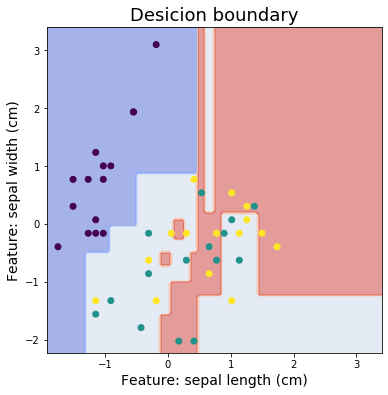

In [223]:
def plot_desicion_boundary(X, Y, target, x_label, y_label):
    n_freq = 100
    
    x_ = np.linspace(1.1 * np.min(X), 1.1 * np.max(Y), n_freq )
    y_ = np.linspace(1.1 * np.min(Y), 1.1 * np.max(Y), n_freq )
    XY_ = np.array([[i, j] for i in x_ for j in y_])

    fig, ax = plt.subplots(figsize=(6, 6))
    pred = np.array(clf.predict(XY_)).reshape((n_freq, n_freq))

    ax.contourf(x_, y_, pred.T, cmap = plt.cm.coolwarm, alpha = 0.5)
    ax.scatter(X, Y, c = target)
    ax.set_xlabel('Feature: {0}'.format(x_label), fontsize=14)
    ax.set_ylabel('Feature: {0}'.format(y_label), fontsize=14)
    ax.set_title('Desicion boundary', fontsize=18)
    
    plt.show()
    
plot_desicion_boundary(X_test[:, 0], X_test[:, 1], y_test, df.columns.values[-3], df.columns.values[-2])

Trees with different depth.

Differnt stop criteria (see notebook) - try via random grid search & pipeline

Composition of algorithms - RF & Grad boosing - see lectures
